# **Capital Deepening Dredging**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

pd.options.display.float_format = '{:,}'.format# show , for thousands
pd.set_option('display.max_columns', 1000)# show all columns

from pathlib import Path

# change the width of the cells on screen 
from IPython.display import display, HTML
display(HTML("<style>.container { width:99% !important; }</style>"))

In [2]:
Dredge_power = 700 #kW
Production_rate_clay = 1800 + 200/(1000-500)*(3000-1800) #m3/h
Production_rate_sand = 1800 + 200/(1000-500)*(3000-1800)
Production_rate_cemented = 400 + 200/(1000-500)*(700-400)

for soil_type, production_rate in zip(['clay', 'sand', 'cemented sand'], 
                                      [Production_rate_clay, Production_rate_sand, Production_rate_cemented]):
    print(f'Production rate of {soil_type}: {production_rate:.1f} m3/h')
    print(f'Maximum weekly production rate of {soil_type}: {production_rate*24*7:.1f} m3/week\n')

Production rate of clay: 2280.0 m3/h
Maximum weekly production rate of clay: 383040.0 m3/week

Production rate of sand: 2280.0 m3/h
Maximum weekly production rate of sand: 383040.0 m3/week

Production rate of cemented sand: 520.0 m3/h
Maximum weekly production rate of cemented sand: 87360.0 m3/week



**Transporting Clay to disposal site**

In [3]:
Barge_capacity = 5500 #m3
barge_velocity = 4 #knots
offshore_distance = 10 #km

**Transporting clay and cemented material using pipeline**

In [4]:
rho_sand = 2000
rho_water = 1025
rho_cemented = 2400
rho_clay = 1800
rho_mixture = 1500
rho_mixture_cemented = 1250

#Sand
n_sand = 0.5
k0_sand= 2.5 * 10**-5
k1_sand = 5 * 10**-5
friction_angle_sand= 30

#Cemented
n_cemented = 0.32
k0_cemented = 2*10**-6
k1_cemented = 5*10**-6
friction_angle_cemented = 30

#clay
n_clay = 0.55
k0_clay = 1*10**-9
k1_clay = 1 * 10**-6
friction_angle_clay = 15

def calc_vm(Qg,rho_s, rho_w, rho_m, n0, D, ft = 1):
    return Qg*(rho_s-rho_w)*(1-n0) / ((rho_m-rho_w)*np.pi/4*D**2) /ft
print('Velocity clay (0.8 m diameter):', round(calc_vm(Qg = 1,rho_s = rho_clay, rho_w = rho_water, rho_m = rho_mixture, n0 = n_clay, D=0.8),2), 'm/s')
print('Velocity sand (0.8 m diameter):', round(calc_vm(Qg = 1,rho_s = rho_sand, rho_w = rho_water, rho_m = rho_mixture, n0 = n_sand, D=0.8),2), 'm/s')
print('Velocity cemented sand (0.8 m diameter):', round(calc_vm(Qg = 1,rho_s = rho_cemented, rho_w = rho_water, rho_m = rho_mixture_cemented, n0 = n_cemented, D=0.8),2), 'm/s')

Velocity clay (0.8 m diameter): 1.46 m/s
Velocity sand (0.8 m diameter): 2.04 m/s
Velocity cemented sand (0.8 m diameter): 8.27 m/s


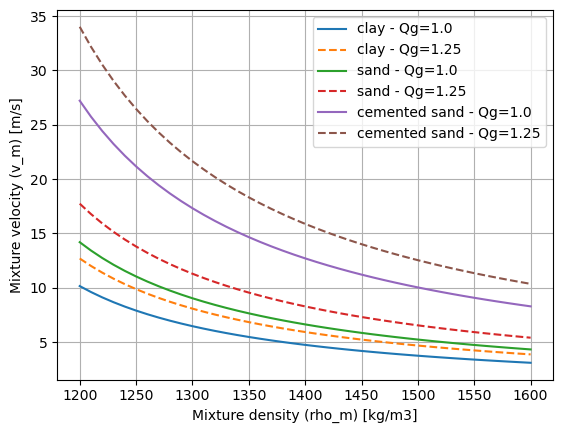

In [5]:
# compute vm series per soil type
D = 0.5
rho_s_list = [rho_clay, rho_sand, rho_cemented]
n0_list = [n_clay, n_sand, n_cemented]
soil_names = ['clay', 'sand', 'cemented sand']

rho_serie = np.arange(1200,1600+10,10)
vm_avg_series = []
vm_peak_series = []

for rho_s_val, n0_val, rho_m in zip(rho_s_list, n0_list, rho_serie):
    vm_avg_series.append([calc_vm(Qg=1.0, rho_s=rho_s_val, rho_w=rho_water, rho_m=rho_m, n0=n0_val, D=D)
                          for rho_m in rho_serie])
    vm_peak_series.append([calc_vm(Qg=1.25, rho_s=rho_s_val, rho_w=rho_water, rho_m=rho_m, n0=n0_val, D=D)
                           for rho_m in rho_serie])

for name, vm_avg_s, vm_peak_s in zip(soil_names, vm_avg_series, vm_peak_series):
    plt.plot(rho_serie, vm_avg_s, label=f'{name} - Qg=1.0')
    plt.plot(rho_serie, vm_peak_s, '--', label=f'{name} - Qg=1.25')

plt.xlabel('Mixture density (rho_m) [kg/m3]')
plt.ylabel('Mixture velocity (v_m) [m/s]')
plt.legend()
plt.grid(True)
plt.show()

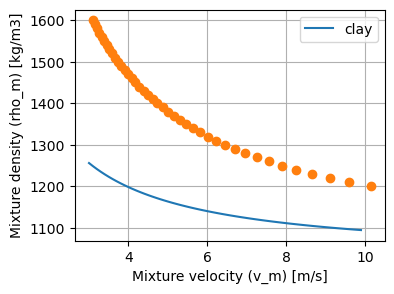

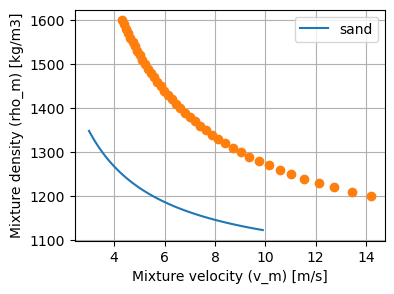

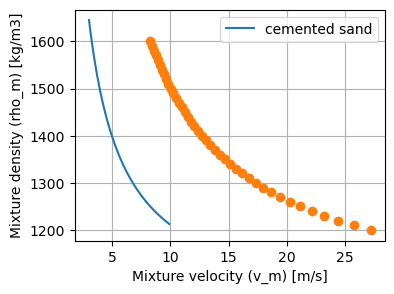

Formula is correct; plotted rho_m vs vm for each soil.


In [6]:
Pipe_D = 0.8
A = 0.25*np.pi*D**2

def calc_rho_m(Q,A,n,ft,rho_s,rho_w,vm):
    C1 = Q/A * (1-n) / ft
    return (C1*rho_s - C1*rho_w + rho_w*vm)/vm

vm_serie = np.arange(3,10,0.1)
rho_m_per_soil = (rho_mixture, rho_mixture, rho_mixture_cemented)
# plot results
for name, rho_series in zip(soil_names, rho_m_per_soil):
    D = Pipe_D
    A = 0.25*np.pi*D**2

    vm_serie = np.arange(3,10,0.1)

    # compute rho_m over the vm range for each soil (use corresponding n0)
    rho_m_per_soil = []
    for rho_s, n0 in zip(rho_s_list, n0_list):
        rho_m_per_soil.append([
            calc_rho_m(Q=1.0, A=A, n=n0, ft=1, rho_s=rho_s, rho_w=rho_water, vm=vm)
            for vm in vm_serie])

for i, (name, rho_series) in enumerate(zip(soil_names, rho_m_per_soil)):
    plt.figure(figsize=(4,3))
    plt.plot(vm_serie, rho_series, label=name)
    plt.plot(vm_avg_series[i], rho_serie, 'o')  # mark the previous points for Qg=1
    plt.xlabel('Mixture velocity (v_m) [m/s]')
    plt.ylabel('Mixture density (rho_m) [kg/m3]')
    plt.legend()
    plt.grid(True)
    plt.show()
print('Formula is correct; plotted rho_m vs vm for each soil.')

In [7]:
L = 1000 #m from basin to LR area
resistance_coefficient = 0.012
Pipe_D = 0.8

def calc_Delta_P(lambda_, rho_m,rho_w,L,D,v):
    g=9.81
    return 1/2*lambda_ * rho_m /rho_w *L/D*(v**2)/g*rho_m*g

v = 1/(0.25*np.pi*Pipe_D**2) # Q (1 m3/s) / A [m2]

def calc_Delta_P2(rho_m,He):
    return rho_m*9.81*He

rho_m = [rho_mixture, rho_mixture, rho_mixture_cemented]
for soil_name, rho, n, He in zip(soil_names, (rho_m), (n0_list), (15,18,19.5)):    
    DeltaP1 = calc_Delta_P(lambda_ = 0.012, rho_m = rho, rho_w=rho_water, L = 1000,D = Pipe_D,v = v)
    DeltaP2 = calc_Delta_P2(rho, He)
    Total_Delta_P = DeltaP1 + DeltaP2

    print(soil_name)
    print(f'  - Delta P 1: {DeltaP1/1000:.2f} kN/m2')
    print(f'  - Delta P 2: {DeltaP2/1000:.2f} kN/m2')
    print(f'  - Total Delta P: {Total_Delta_P/1000:.2f} kN/m2\n')



clay
  - Delta P 1: 65.16 kN/m2
  - Delta P 2: 220.72 kN/m2
  - Total Delta P: 285.88 kN/m2

sand
  - Delta P 1: 65.16 kN/m2
  - Delta P 2: 264.87 kN/m2
  - Total Delta P: 330.03 kN/m2

cemented sand
  - Delta P 1: 45.25 kN/m2
  - Delta P 2: 239.12 kN/m2
  - Total Delta P: 284.37 kN/m2



In [8]:
D = 0.8
A = 0.25 * np.pi * D**2

def calc_cv(rho_m, rho_w, rho_s):
    return (rho_m - rho_w) / (rho_s - rho_w)

def calc_Es(n0, delta_P, cv):
    return (1 - n0) * delta_P / cv

pump_eff = 0.8   # pump efficiency (fraction)
Q_flow = Qavg/1000    # m3/s used in calc_rho_m and power calc

Delta_P_series_all = []
Ph_series_all = []

for rho_s, n0, He, soil in zip(rho_s_list, n0_list, (15, 18, 19.5), soil_names):
    Delta_P_serie = []
    Ph_serie = []
    for vm in vm_serie:
        # compute mixture density for given vm and soil parameters
        rho_m = calc_rho_m(Q=Q_flow, A=A, n=n0, ft=1, rho_s=rho_s, rho_w=rho_water, vm=vm)

        # pressure losses: P1 (friction) and P2 (static/elevation)
        P1 = calc_Delta_P(lambda_=resistance_coefficient, rho_m=rho_m, rho_w=rho_water, L=L, D=D, v=vm)
        P2 = calc_Delta_P2(rho_m, He)
        Delta_P = P1 + P2

        # store as kPa for plotting
        Delta_P_serie.append(Delta_P / 1000.0)

        # pump power required [kW] for Q_flow (m3/s): Power (kW) = Delta_P(Pa)*Q(m3/s)/1000, account for efficiency
        Ph = (Delta_P * Q_flow) / 1000.0 / pump_eff
        Ph_serie.append(Ph)
    plt.plot(vm_serie, Delta_P_serie, label=soil)
    Delta_P_series_all.append(Delta_P_serie)
    Ph_series_all.append(Ph_serie)
plt.xlabel('Mixture velocity (vm) [m/s]')
plt.ylabel('Total pressure head [kPa]')
plt.title ('Total pressure loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot pump power required
for soil, Ph_serie in zip(soil_names, Ph_series_all):
    plt.plot(vm_serie, Ph_serie, label=soil)
plt.xlabel('Mixture velocity (vm) [m/s]')
plt.ylabel('Pump power [kW]')
plt.title('Required power')
plt.legend()
plt.grid(True)
plt.show()

NameError: name 'Qavg' is not defined

In [ ]:
def V_trench(B,H,phi,L):#phi in degrees, B = bottom width, H = layer thickness
    phi_rad = phi*np.pi/180
    A = H*(B+H/np.tan(phi_rad))*L
    B1 = B + 2*H/np.tan(phi_rad)
    return A,B1

V_sand, B_top_sand = V_trench(B = 200,H = 3,phi = 30, L=750) 
V_clay, B_top_clay = V_trench(B = 200,H = 2,phi = 15, L=750)
V_cemented, B_top_cemented = V_trench(B = 200,H = 1.5,phi = 30, L=750)
print('Volume of sand:', round(V_sand,0) ,'m3, top width:', round(B_top_sand,0), 'm')
print('Volume of clay:', round(V_clay,0) ,'m3, top width:', round(B_top_clay,0), 'm')
print('Volume of cemented sand:', round(V_cemented,0) ,'m3, top width:', round(B_top_cemented,0), 'm \n')

In [ ]:
rho_mix = 1500
rho_water = 1025
rho_sand = 2000
rho_cemented = 2400
rho_clay = 1800
Barges_velocity = 4 #knots
distance = 11 #km
distance_LR = 1 #km
distance_MF = 1 #km
Barge_capacity = 5500 #m3
t_manouvering = 15 #minutes
t_discharge = 10 #minutes
workability = 0.7

time_sailing_outside = distance*1000/(Barges_velocity*0.514444*60) #minutes
time_sailing_inside = distance_LR*1000/(Barges_velocity*0.514444*60) #minutes
print(f'Time sailing disposal:', round(time_sailing_outside,0), 'minutes')
print(f'Time sailing LR and MF area:', round(time_sailing_inside,0), 'minutes\n')


sediment = ['Clay', 'Sand', 'Cemented']
production_rate = [Production_rate_clay, Production_rate_sand, Production_rate_cemented]
volume = [V_clay, V_sand, V_cemented]

for sediment, rho, prod, volume in zip(sediment,[rho_clay, rho_sand, rho_cemented], production_rate, volume):
    solid_percentage = (rho_mix - rho_water) / (rho - rho_water)
    mass_dry = prod * rho
    mass_mix = mass_dry / solid_percentage
    volume_mix = mass_mix / rho_mix
    Load_time = Barge_capacity*60 / volume_mix  # mins

    if sediment == 'Cemented':
        t_cycle = 2*time_sailing_outside + Load_time + t_discharge + t_manouvering
    else:
        t_cycle = 2*time_sailing_inside + Load_time + t_discharge + t_manouvering

    volume_cycle = Barge_capacity* solid_percentage
    sediment_mass_cycle = volume_cycle * rho

    n_cycles = volume / volume_cycle
    no_barges = 1
    total_cycle_minutes = n_cycles * t_cycle
    total_working_hours = total_cycle_minutes / 60

    #Cutter head maintenance calculations
    inspection_interval_hours = 50           # inspect every 100 operating hours
    replacement_wear_fraction = 0.40            # replace after ~50% wear
    teeth_per_head = 10                         # Beaver 65 typical
    downtime_per_tooth = 0.5                    # hours per tooth (~30 min)

    total_replacements = total_working_hours / (inspection_interval_hours / replacement_wear_fraction)
    replacement_downtime_hours = total_replacements * teeth_per_head * downtime_per_tooth

    adjusted_total_working_hours = total_working_hours + replacement_downtime_hours
    total_days = adjusted_total_working_hours / 20
    total_weeks = total_days / (7)

    print(f'{sediment}:')
    print('For soil density of', rho, 'kg/m3, loading time is', round(Load_time,1), 'minutes')
    print('Total cycle time of', rho, 'kg/m3 is', round(t_cycle,0), 'minutes')
    print(f"Sediment volume per cycle: {volume_cycle:.0f} m³")
    print(f"total_working_hours: {total_working_hours:.1f} hours")
    print(f'total cycles required : {n_cycles:.0f} cycles')
    print(f'Total weeks required : {total_weeks:.1f} weeks\n')



**Calculation of cavitation**

In [ ]:
#CLAY
n0_cemented = 0.22
n1_cemented = 0.32
k0_cemented = 2 * 10**-6
k1_cemented = 5 * 10**-6
phi_cemented  = 30

v = 5 #m/s
h = 0.2 #m
alpha = 45 #deg
delta = 20 #deg

def calc_dn(n0_cemented,n1_cemented):
    return (n1_cemented-n0_cemented)/(1-n1_cemented)

print('Dillation (Delta n):', round(calc_dn(n0_cemented,n1_cemented),4))

def calc_k_mean(k0_cemented,k1_cemented):
    return (k0_cemented+k1_cemented)/2

k_mean = calc_k_mean(k0_cemented,k1_cemented)
print('Average permeability(k mean):', round(k_mean, 10))

def calc_p2_NO_cavitation(rho_w,b,h,v,k,delta_n):
    return 0.33*rho_w*9.81*b*h**2*(v/k)*delta_n

P2_NO_cavit = calc_p2_NO_cavitation(rho_w=1025,b=1,h=0.2,v=5,k=k_mean,delta_n = 0.2)
print('The force P2 non cavitation:', round(P2_NO_cavit/1e3, 2) , 'kN/m')
print('The force P2 non cavitation:', round(P2_NO_cavit/1e6, 2) , 'MN/m\n')

z1 = 8
z2 = 10
def calc_z_mean(z1,z2):
    return(z1+z2)/2

z_mean = calc_z_mean(z1,z2)
print('The average elevation (z mean):', z_mean , 'm')

def calc_P2_cavitation(rho_w,b,h,z,beta):
    beta_rad = beta*np.pi/180
    return rho_w*9.81*b*h*(z+10)/np.sin(beta_rad)

P2_cavit = calc_P2_cavitation(rho_w =1025,b=1,h=0.2,z=z_mean,beta=30)

print('The force P2:',round(P2_cavit/1e3, 2) , 'kN/m')
print('The force P2:',round(P2_cavit/1e6, 2) , 'N/m 1e6')

P2_NO_cavit_serie = []
P2_cavit_serie = []

angle_serie = np.arange(30,45+1,1)

for beta in angle_serie:
    P2_NO_cavit_serie.append(calc_p2_NO_cavitation(rho_w=1025,b=1,h=0.2,v=5,k=k_mean,delta_n = 0.2)*np.sin(beta*np.pi/180))# multiply by angle in addition to formula
    P2_cavit_serie.append(calc_P2_cavitation(rho_w =1025,b=1,h=0.2,z=z_mean,beta=beta))


# # plt.plot(angle_serie, P2_NO_cavit_serie, label = 'non cavitating')
# # plt.plot(angle_serie, P2_cavit_serie, label = 'cavitating')
# plt.legend();
# plt.xlabel(r'Shear angle ($\beta$) [$\degree$]')
# plt.ylabel('Cutting force [N/m]')

print('the lowest value will take place, so this situation will be cavitating')

In [ ]:
def calc_P1_cav(rho,b,h,alpha,z): # It follows the book, however the sugestion is that h should be h_blade, which influences the friction along the blade.
    return rho*9.81*b*h*(z+10)/np.sin(alpha*np.pi/180)

def calc_P2_cavitation(rho_w,b,h,z,beta): # used before, is correct
    beta_rad = beta*np.pi/180
    return rho_w*9.81*b*h*(z+10)/np.sin(beta_rad)

def calc_Fh(P1,P2,alpha,beta,delta,phi):
    return (P2*np.sin(phi*np.pi/180)*np.sin((alpha+delta)*np.pi/180)+P1*np.sin(delta*np.pi/180)*np.sin((beta+phi)*np.pi/180))/np.sin((alpha+beta+delta+phi)*np.pi/180)

beta_serie = np.arange(30,40+1,0.1)

Fh =[]
for beta in beta_serie:
    P1 = calc_P1_cav(rho = 1025,b=1,h=0.2,alpha=45, z = z_mean)
    P2 = calc_P2_cavitation(rho_w =1025,b=1,h=0.2,z=z_mean,beta=beta)
    Fh.append(calc_Fh(P1,P2,alpha=45,beta=beta,delta=delta,phi=phi_clay))

plt.plot(beta_serie, Fh);
plt.xlabel('shear angle (beta) [$\degree$]')
plt.ylabel('Cutting Force [N/m]');

index_lowest = np.where(Fh == np.min(Fh))[0][0]
optimal_angle = beta_serie[index_lowest] 

print('The optimal angle:', round(optimal_angle,2), 'degrees')


In [ ]:

def calc_Fv(P1,P2,alpha,beta,delta,phi):
    return (P2*np.sin(phi*np.pi/180)*np.cos((alpha+delta)*np.pi/180)-P1*np.sin(delta*np.pi/180)*np.cos((beta+phi)*np.pi/180))/np.sin((alpha+beta+delta+phi)*np.pi/180)

#Required cutting force
P1 = calc_P1_cav(rho = rho_sand,b=1,h=0.2,alpha=45, z = z_mean)
P2 = calc_P2_cavitation(rho_w =1025,b=1,h=0.2,z=z_mean,beta=optimal_angle)

Fv = calc_Fv(P1,P2,alpha = 45,beta = optimal_angle,delta = 0.2,phi=35)
print('The vertical force:', round(Fv/1000,1), 'kN/m')

Fh = calc_Fh(P1,P2,alpha=45,beta=optimal_angle,delta=20,phi=35)

F = (Fh**2+Fv**2)**0.5
print('The total cutting force:', round(F/1000,0), 'kN\n')

#Specific Energy
P1 = calc_P1_cav(rho = 1025,b=1,h=0.2,alpha=45, z = z_mean)
P2 = calc_P2_cavitation(rho_w =1025,b=1,h=0.2,z=z_mean,beta=optimal_angle)
Fh = calc_Fh(P1,P2,alpha=45,beta=optimal_angle,delta=20,phi=35)

E_spec = Fh/0.2
print('The specific Energy:', round(E_spec/1000,1), 'kN/m2')

P_cut = E_spec/(0.8*(1-0.15))
print('Required cutting power:', round(P_cut/1000,1), 'kW')

In [ ]:
rho_s = 2650
Production_rate_clay = 1800 + 200/(1000-500)*(3000-1800) #m3/h
Production_rate_sand = 1800 + 200/(1000-500)*(3000-1800)
Production_rate_cemented = 400 + 200/(1000-500)*(700-400)

density = {'clay': 1800, 'sand': 2000, 'cemented sand': 2400}
fines = {'clay': 1, 'sand': 0.35, 'cemented sand': 0.04}
overflow = pd.DataFrame()
overflow['Soil'] =['clay', 'sand', 'cemented sand']
overflow['Equipment'] = ['CSD + Barge A', 'CSD + Barge A', 'CSD + Barge A'] 
overflow['in-situ vol [m3]'] = [round(V_clay,0), round(V_sand,0), round(V_cemented,0)]
overflow['production [m3/week]'] = [Production_rate_clay*7*20, Production_rate_sand*7*20, Production_rate_cemented*7*20]
overflow['density'] =  overflow['Soil'].map(density)
overflow['fines'] =  overflow['Soil'].map(fines)
overflow['sigma_place'] = [0.08, 0.02, 0.13]
overflow['sigma_dredge'] = [0,0 ,0]

display(overflow)

In [ ]:
def calc_dry_dens(rho_situ, rho_s, rho_w, Srw):
    n = (rho_situ-rho_s)/(Srw*rho_w-rho_s)
    return (1-n)*rho_s

rho_s = 2650
rho_w = rho_water
Srw = 1
overflow['dry density'] = round((1-(overflow['density']- rho_s)/(Srw*rho_w-rho_s))*rho_s,2)
#overflow['dry density'] = overflow.apply(lambda row: calc_dry_dens(rho_situ = row['density'], rho_s = 2650, rho_w = 1025, Srw  =1), axis = 1)

overflow['mt'] = round(overflow['dry density']*overflow['in-situ vol [m3]']*overflow['fines']/1000,2)

display(overflow)

In [ ]:
overflow['md'] = round(overflow['sigma_dredge'] * overflow['mt'],2)
overflow['mh'] = round(overflow['mt'] - overflow['md'],2)
display(overflow)